## 4. Gradient-boosted decision trees, Nueral Network, K-Nearest Neighbours, Gaussian Naive Bayes, Voting Ensemble

In [76]:
#import library
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

#analysis target
how_much_better = 20
invest_unit_per_stock = 1
current_key_stats = datetime.datetime(2018, 2, 5, 0, 0)

#analysis features
Analysis_Features = [
                     'Market Cap',
                     'Enterprise Value',
                     'Trailing P/E',
                     'Forward P/E',
                     'PEG Ratio',
                     'Price/Sales',
                     'Enterprise Value/Revenue',
                     'Profit Margin',
                     'Operating Margin', 
                     'Return on Equity',
                     'Revenue',
                     'Revenue Per Share',                         
                     'Net Income Avl to Common',
                     'Diluted EPS',
                     'Total Cash',
                     'Total Cash Per Share',
                     'Total Debt',
                     'Book Value Per Share',
                     'Operating Cash Flow',
                     'Beta',
                     '% Held by Insiders',
                     '% Held by Institutions',
                     'Shares Short', 
                     'Short Ratio'
                    ]   

### Stock ranking

In [77]:
#define function to rank stock based on differences between stock price changes & S&P 500 index changes
def Rank_Stock(row):  
    if row['Stock Price vs S&P 500 Index'] > how_much_better:
        #print(row['Ticker'], row['Stock Price vs S&P 500 Index'])
        return 1
    else:
        return 0
    
#define function to rank stock based on differences compare to its previous price
def Rank_Stock_By_Historical(row):
    if row["Stock Price Change"] > how_much_better:
        #print(row['Ticker'], row["Stock Price Change"])
        return 1
    else:
        return 0

### Data load

In [78]:
#define function to load historical data
def Load_Historical_Data():
    historical_data_path = os.path.join(os.path.join(os.getcwd(), 'Data'), "Historical.csv")
    df = pd.read_csv(historical_data_path, sep=',')#.iloc[:,1:]
    return df

#define function to load forward data
def Load_Forward_Data():
    forward_data_path = os.path.join(os.path.join(os.getcwd(), 'Data'), "Forward.csv")
    df = pd.read_csv(forward_data_path, sep=',')#.iloc[:,1:]
    return df

### Load Yahoo Finance stock price

In [79]:
#using 3rd party code from https://github.com/c0redumb/yahoo_quote_download to download stock price from Yahoo Finance
import yahoo_quote_download as yqd
from datetime import datetime, timedelta
import pandas as pd

def load_quote(ticker, startDate, endDate, search_method='F', count=0):
    count+=1
#     if startDate.weekday() == 5:
#         startDate = startDate + timedelta(days=2)
#     elif startDate.weekday() == 6:
#         startDate = startDate + timedelta(days=1)
        
#     if endDate.weekday() == 5:
#         endDate = endDate + timedelta(days=2)
#     elif endDate.weekday() == 6:
#         endDate = endDate + timedelta(days=1)
        
    start = startDate.strftime('%Y%m%d')
    end = endDate.strftime('%Y%m%d')    
    data = yqd.load_yahoo_quote(ticker, start, end)   
#     print('===', ticker, start, end, search_method, count, data,'===')
    df = pd.DataFrame([sub.split(",") for sub in data if len(sub.split(",")[0])>0 and sub.split(",")[0] != 'Date'], columns=['Date','Open','High','Low','Close','Adj Close','Volume'])    
      
    if len(df) == 0 and count < 10:
        value = None
        if search_method=='F':
            startDate = startDate + timedelta(days=1)
            endDate = endDate + timedelta(days=1)
        else:
            startDate = startDate - timedelta(days=1)
            endDate = endDate - timedelta(days=1)
            
        return load_quote(ticker, startDate, endDate, search_method, count)
    else:        
        value = df.iloc[0]['Adj Close'] if len(df) > 0 else None
    return value#df

### Check for NaN value in data

In [80]:
def Check_Null_Data(df):
    #check for NaN data   
    #as there're a lot of N/A data, cautious approach will be implemented for stock analysis to follow rules of:
    #1) Avoid loss 
    #2) Do not forget rule#1
    #All N/A data found in key features used for analysis will be removed.
    return df.isnull().sum() 

### Data cleaning and null value handling

In [81]:
#define function to preprocess data
def Historical_Data_Preprocessing_All_Industry(df, ranking=0): 
    #df = Load_Historical_Data()
    
    #drop row with any NA value based on Analysis Features + Stock Price 
    df = df.dropna(subset=['Stock Price']+Analysis_Features, how='any').reset_index().drop(['index'], axis=1)  
        
    #features data set
    X = df[Analysis_Features]  
    
    #label data set    
    if ranking==0:
        df['Ranking'] = df.apply(Rank_Stock, axis=1)
    else:
        df['Ranking'] = df.apply(Rank_Stock_By_Historical, axis=1)
    y = df['Ranking']
    
    return X,y

#define function to preprocess data
def Forward_Data_Preprocessing_All_Industry(df): 
    #df = Load_Forward_Data()
    
    #drop row with any NA value based on Analysis Features + Stock Price 
    df = df.dropna(subset=['Ticker','Security','GICS Sector','GICS Sub Industry']+Analysis_Features, how='any').reset_index().drop(['index'], axis=1)
       
    #features data set
    X = df[Analysis_Features]
    
    #Listed company data set 
    z = df[['Ticker','Security','GICS Sector','GICS Sub Industry']]    
        
    return X,z

### Train and Test Dataset Split

In [82]:
from sklearn.model_selection import train_test_split

def Train_Test_Split(X, y):
    #For the sake of testing our classifier output, we will split the data into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    #X_columns = list(X_train)
    return X_train, X_test, y_train, y_test

### Feature Scaling and Normalization

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def Standard_Scale(X_train, X_test, X_ver):
    scaler = StandardScaler()
    #standard scale transform
    X_train_std_scale = scaler.fit_transform(X_train)
    X_test_std_scale = scaler.transform(X_test)
    X_ver_std_scale = scaler.transform(X_ver)
    return X_train_std_scale, X_test_std_scale, X_ver_std_scale

def MinMax_Scale(X_train, X_test, X_ver):
    scaler = MinMaxScaler()
    #MinMax scale transform
    X_train_mm_scale = scaler.fit_transform(X_train)
    X_test_mm_scale = scaler.transform(X_test)
    X_ver_mm_scale = scaler.transform(X_ver)
    return X_train_mm_scale, X_test_mm_scale, X_ver_mm_scale

### PCA - choosing number of components

In [84]:
from sklearn.decomposition import PCA

def PCA_Component_Analysis(X_train):
    pca = PCA()
    X_train_PCA = pca.fit_transform(X_train) #fit_transform X_train

    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show();
    
def PCA_Component_Selection(n_components, X_train, X_test, X_ver):
    #choose 15 components for PCA to reduce features
    pca = PCA(n_components=n_components)

    X_train_PCA = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)
    X_ver_PCA = pca.transform(X_ver)
    return X_train_PCA, X_test_PCA, X_ver_PCA

### Imbalance dataset handling

In [85]:
from imblearn.under_sampling import RandomUnderSampler

def Down_Sample_Dataset(X, y):  
    rus = RandomUnderSampler(return_indices=True, random_state=42)
    X_undersampling, y_undersampling, idx_resampled = rus.fit_sample(X, y)
    print('Y before down-sampling:', np.unique(y,return_counts=True))
    print('Y after down-sampling:', np.unique(y_undersampling,return_counts=True))
    return X_undersampling, y_undersampling

### Model Execution with GridSearch k-Nearest Neighbours

In [86]:
def GridSearch_KNN_Run(X_train, y_train, X_test, y_test, X_ver, calc_return=True):
    from sklearn.model_selection import GridSearchCV
    from sklearn.neighbors import KNeighborsClassifier
    model = KNeighborsClassifier(n_jobs=-1)

    # Create the weight function used in prediction
    weights =  ['uniform', 'distance']

    # Create the number of neighbors to use 
    n_neighbors = np.arange(2, 15)
    
    # Create hyperparameter options
    hyperparameters = dict(weights=weights, n_neighbors=n_neighbors)   

    # Create grid search using 5-fold cross validation
    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

    # Fit grid search
    best_model = clf.fit(X_train, y_train)

    # View best hyperparameters
    print('GridSearch KNN Best weights:', best_model.best_estimator_.get_params()['weights'])
    print('GridSearch KNN Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

    # KNN Default accuracy 
    print('GridSearch KNN Default (accuracy) Train Dataset', best_model.score(X_train, y_train))
    print('GridSearch KNN Default (accuracy) Test Dataset', best_model.score(X_test, y_test))
    print()

    # KNN Default metric report
    from sklearn import metrics
    y_pred = best_model.predict(X_test)
    print('GridSearch KNN Default Metric Report:')
    print(metrics.classification_report(y_pred, y_test))

    # KNN Default Confusion Matrix
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    print('GridSearch KNN Default Confusion Matrix:')
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show();

    # Calculate AUROC
    from sklearn.metrics import roc_auc_score   
    y_prob = best_model.predict_proba(X_test)
    y_prob = [p[1] for p in y_prob]

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    auc_result = auc(fpr, tpr)
    print('GridSearch KNN ROC Curve')
    print('AUROC Score:',roc_auc_score(y_test, y_prob))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    #test with latest stock key statistic
    import datetime
    print('Predict using latest Key Statistic @ {0}'.format(current_key_stats.strftime('%Y-%m-%d')))   
    y_pred = best_model.predict(X_ver)

    counter=0
    invest_list = []
    initial_price = []
    current_price = []
    investment_cost = []
    investment_return = []
    profit_loss = []
    for t in y_pred:   
         if t == 1:                
            invest_list.append(z.iloc[counter]['Security'])            
            if calc_return == True:        
                ini_price = load_quote(z.iloc[counter]['Ticker'],current_key_stats,current_key_stats,search_method='F')        
                cur_price = load_quote(z.iloc[counter]['Ticker'],datetime.date.today()-timedelta(days=1),datetime.date.today()-timedelta(days=1),search_method='B')  
                if ini_price != None:
                    ini_price = round(float(ini_price),2)
                    inv_cost = round(float(ini_price)*invest_unit_per_stock,2)
                else:
                    inv_cost = None
                if cur_price != None:
                    cur_price = round(float(cur_price),2)
                    inv_return = round(float(cur_price)*invest_unit_per_stock,2)
                else:
                    inv_return = None
                if inv_cost != None and inv_return != None:
                    pl = round(inv_return-inv_cost,2)
                else:
                    pl = None
                
                initial_price.append(ini_price)
                current_price.append(cur_price)
                investment_cost.append(inv_cost)
                investment_return.append(inv_return)
                profit_loss.append(pl)
         counter+=1
    
    print()
    if calc_return == True:
        df_rcmd = pd.DataFrame({
                                'Company':invest_list,
                                'Initial Price':initial_price,
                                'Current Price':current_price,
                                'Investment Cost':investment_cost,
                                'Investment Return':investment_return,
                                'Profit/Loss':profit_loss
                                }
                                , columns=['Company',
                                           'Initial Price',
                                           'Current Price',
                                           'Investment Cost',
                                           'Investment Return',
                                           'Profit/Loss'])
        print('Recommended companies for investment and total return as below:')
        print('Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_rcmd['Profit/Loss'].sum(),2)))
        print('Total investment cost so far is [${0}]'.format(round(df_rcmd['Investment Cost'].sum(),2)))
        print('Total investment return so far is [${0}]'.format(round(df_rcmd['Investment Return'].sum(),2)))
        print('Total investment return % gain so far is [{0}%]'.format(100*round(df_rcmd['Profit/Loss'].sum(),2)/round(df_rcmd['Investment Cost'].sum(),2)))
        print()
        df_top10 = df_rcmd.nlargest(10, 'Profit/Loss').reset_index().drop(['index'],axis=1)
        print('Top 10 companies by investment profit:')
        print('Top 10 Total investment cost so far is [${0}]'.format(round(df_top10['Investment Cost'].sum(),2)))
        print('Top 10 Total investment return so far is [${0}]'.format(round(df_top10['Investment Return'].sum(),2)))
        print('Top 10 Total investment return % gain so far is [{0}%]'.format(100*round(df_top10['Profit/Loss'].sum(),2)/round(df_top10['Investment Cost'].sum(),2)))        
        print(df_top10)
    else:
        print('Recommended companies for investment as below:')
        df_rcmd = pd.DataFrame(invest_list, columns=['Company'])   
    
    return df_rcmd 

### Model Execution with GridSearch Neural Network

In [87]:
def GridSearch_NN_Run(X_train, y_train, X_test, y_test, X_ver, calc_return=True):
    from sklearn.model_selection import GridSearchCV
    from sklearn.neural_network import MLPClassifier  
    model = MLPClassifier(hidden_layer_sizes = [100, 100], solver='lbfgs', random_state=42)

    # Create the activation function used in prediction
    activation =  ['logistic', 'tanh', 'relu']

    # Create the number of alpha to use 
    alpha = [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 50]
    
    # Create hyperparameter options
    hyperparameters = dict(activation=activation, alpha=alpha)   

    # Create grid search using 5-fold cross validation
    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

    # Fit grid search
    best_model = clf.fit(X_train, y_train)

    # View best hyperparameters
    print('GridSearch Neural Network Best activation:', best_model.best_estimator_.get_params()['activation'])
    print('GridSearch Neural Network Best alpha:', best_model.best_estimator_.get_params()['alpha'])

    # Neural Network Default accuracy 
    print('GridSearch Neural Network Default (accuracy) Train Dataset', best_model.score(X_train, y_train))
    print('GridSearch Neural Network Default (accuracy) Test Dataset', best_model.score(X_test, y_test))
    print()

    # Neural Network Default metric report
    from sklearn import metrics
    y_pred = best_model.predict(X_test)
    print('GridSearch Neural Network Default Metric Report:')
    print(metrics.classification_report(y_pred, y_test))

    # Neural Network Default Confusion Matrix
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    print('GridSearch Neural Network Default Confusion Matrix:')
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show();

    # Calculate AUROC
    from sklearn.metrics import roc_auc_score   
    y_prob = best_model.predict_proba(X_test)
    y_prob = [p[1] for p in y_prob]

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    auc_result = auc(fpr, tpr)
    print('GridSearch Neural Network ROC Curve')
    print('AUROC Score:',roc_auc_score(y_test, y_prob))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    #test with latest stock key statistic
    import datetime
    print('Predict using latest Key Statistic @ {0}'.format(current_key_stats.strftime('%Y-%m-%d')))   
    y_pred = best_model.predict(X_ver)

    counter=0
    invest_list = []
    initial_price = []   
    current_price = []
    investment_cost = []
    investment_return = []
    profit_loss = []
    for t in y_pred:   
         if t == 1:                
            invest_list.append(z.iloc[counter]['Security'])            
            if calc_return == True:        
                ini_price = load_quote(z.iloc[counter]['Ticker'],current_key_stats,current_key_stats,search_method='F') 
                cur_price = load_quote(z.iloc[counter]['Ticker'],datetime.date.today()-timedelta(days=1),datetime.date.today()-timedelta(days=1),search_method='B')  
                if ini_price != None:
                    ini_price = round(float(ini_price),2)
                    inv_cost = round(float(ini_price)*invest_unit_per_stock,2)
                else:
                    inv_cost = None                          
                if cur_price != None:
                    cur_price = round(float(cur_price),2)
                    inv_return = round(float(cur_price)*invest_unit_per_stock,2)
                else:
                    inv_return = None
                if inv_cost != None and inv_return != None:
                    pl = round(inv_return-inv_cost,2)
                else:
                    pl = None
                    
                initial_price.append(ini_price)                
                current_price.append(cur_price)
                investment_cost.append(inv_cost)
                investment_return.append(inv_return)
                profit_loss.append(pl)
         counter+=1
    
    print()
    if calc_return == True:
        df_rcmd = pd.DataFrame({
                                'Company':invest_list,
                                'Initial Price':initial_price,
                                'Current Price':current_price,
                                'Investment Cost':investment_cost,
                                'Investment Return':investment_return,
                                'Profit/Loss':profit_loss
                                }
                                , columns=['Company',
                                           'Initial Price',
                                           'Current Price',
                                           'Investment Cost',
                                           'Investment Return',
                                           'Profit/Loss'])
        print('Recommended companies for investment and total return as below:')
        print('Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_rcmd['Profit/Loss'].sum(),2)))
        print('Total investment cost so far is [${0}]'.format(round(df_rcmd['Investment Cost'].sum(),2)))
        print('Total investment return so far is [${0}]'.format(round(df_rcmd['Investment Return'].sum(),2)))
        print('Total investment return % gain so far is [{0}%]'.format(100*round(df_rcmd['Profit/Loss'].sum(),2)/round(df_rcmd['Investment Cost'].sum(),2)))
        print()
        df_top10 = df_rcmd.nlargest(10, 'Profit/Loss').reset_index().drop(['index'],axis=1)
        print('Top 10 companies by investment profit:')
        print('Top 10 Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_top10['Profit/Loss'].sum(),2)))
        print('Top 10 Total investment cost so far is [${0}]'.format(round(df_top10['Investment Cost'].sum(),2)))
        print('Top 10 Total investment return so far is [${0}]'.format(round(df_top10['Investment Return'].sum(),2)))
        print('Top 10 Total investment return % gain so far is [{0}%]'.format(100*round(df_top10['Profit/Loss'].sum(),2)/round(df_top10['Investment Cost'].sum(),2)))        
        print(df_top10)
    else:
        print('Recommended companies for investment as below:')
        df_rcmd = pd.DataFrame(invest_list, columns=['Company'])   
    
    return df_rcmd 

### Model Execution with GridSearch for Gradient-Boosted Decision Trees

In [88]:
def GridSearch_GBM_Run(X_train, y_train, X_test, y_test, X_ver, calc_return=True, printFeatureImportance=True):
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import GradientBoostingClassifier    

    model = GradientBoostingClassifier(random_state=42)

    # Create the number of trees in the forest
    n_estimators = [50,100,150,200] 

    # Create the maximum depth of the tree
    max_depth = [5,10,15]
    
    # Create the learning rate of the tree
    learning_rate = [0.05, 0.1, 0.15, 0.2]

    # Create hyperparameter options
    hyperparameters = dict(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate)

    # Create grid search using 5-fold cross validation
    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

    # Fit grid search
    best_model = clf.fit(X_train, y_train)

   # View best hyperparameters
    print('GridSearch Gradient-Boosted Decision Trees Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
    print('GridSearch Gradient-Boosted Decision Trees Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
    print('GridSearch Gradient-Boosted Decision Trees Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])

    # Gradient-Boosted Decision Trees Default accuracy 
    print('GridSearch Gradient-Boosted Decision Trees Default (accuracy) Train Dataset', best_model.score(X_train, y_train))
    print('GridSearch Gradient-Boosted Decision Trees Default (accuracy) Test Dataset', best_model.score(X_test, y_test))
    print()
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(best_model.best_estimator_.feature_importances_, Analysis_Features).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show();
        print()

    # Random Forest Default metric report
    from sklearn import metrics
    y_pred = best_model.predict(X_test)
    print('GridSearch Gradient-Boosted Decision Trees Default Metric Report:')
    print(metrics.classification_report(y_pred, y_test))

    # Random Forest Default Confusion Matrix
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    print('GridSearch Gradient-Boosted Decision Trees Default Confusion Matrix:')
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show();

    # Calculate AUROC
    from sklearn.metrics import roc_auc_score   
    y_prob = best_model.predict_proba(X_test)
    y_prob = [p[1] for p in y_prob]

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    auc_result = auc(fpr, tpr)
    print('GridSearch Gradient-Boosted Decision Trees ROC Curve')
    print('AUROC Score:',roc_auc_score(y_test, y_prob))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    #test with latest stock key statistic
    import datetime
    print('Predict using latest Key Statistic @ {0}'.format(current_key_stats.strftime('%Y-%m-%d')))   
    y_pred = best_model.predict(X_ver)

    counter=0
    invest_list = []
    initial_price = []
    current_price = []
    investment_cost = []
    investment_return = []
    profit_loss = []
    for t in y_pred:   
         if t == 1:                
            invest_list.append(z.iloc[counter]['Security'])            
            if calc_return == True:        
                ini_price = load_quote(z.iloc[counter]['Ticker'],current_key_stats,current_key_stats,search_method='F')        
                cur_price = load_quote(z.iloc[counter]['Ticker'],datetime.date.today()-timedelta(days=1),datetime.date.today()-timedelta(days=1),search_method='B')  
                if ini_price != None:
                    ini_price = round(float(ini_price),2)
                    inv_cost = round(float(ini_price)*invest_unit_per_stock,2)
                else:
                    inv_cost = None
                if cur_price != None:
                    cur_price = round(float(cur_price),2)
                    inv_return = round(float(cur_price)*invest_unit_per_stock,2)
                else:
                    inv_return = None
                if inv_cost != None and inv_return != None:
                    pl = round(inv_return-inv_cost,2)
                else:
                    pl = None
                
                initial_price.append(ini_price)
                current_price.append(cur_price)
                investment_cost.append(inv_cost)
                investment_return.append(inv_return)
                profit_loss.append(pl)
         counter+=1
    
    print()
    if calc_return == True:
        df_rcmd = pd.DataFrame({
                                'Company':invest_list,
                                'Initial Price':initial_price,
                                'Current Price':current_price,
                                'Investment Cost':investment_cost,
                                'Investment Return':investment_return,
                                'Profit/Loss':profit_loss
                                }
                                , columns=['Company',
                                           'Initial Price',
                                           'Current Price',
                                           'Investment Cost',
                                           'Investment Return',
                                           'Profit/Loss'])
        print('Recommended companies for investment and total return as below:')
        print('Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_rcmd['Profit/Loss'].sum(),2)))
        print('Total investment cost so far is [${0}]'.format(round(df_rcmd['Investment Cost'].sum(),2)))
        print('Total investment return so far is [${0}]'.format(round(df_rcmd['Investment Return'].sum(),2)))
        print('Total investment return % gain so far is [{0}%]'.format(100*round(df_rcmd['Profit/Loss'].sum(),2)/round(df_rcmd['Investment Cost'].sum(),2)))
        print()
        df_top10 = df_rcmd.nlargest(10, 'Profit/Loss').reset_index().drop(['index'],axis=1)
        print('Top 10 companies by investment profit:')
        print('Top 10 Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_top10['Profit/Loss'].sum(),2)))
        print('Top 10 Total investment cost so far is [${0}]'.format(round(df_top10['Investment Cost'].sum(),2)))
        print('Top 10 Total investment return so far is [${0}]'.format(round(df_top10['Investment Return'].sum(),2)))
        print('Top 10 Total investment return % gain so far is [{0}%]'.format(100*round(df_top10['Profit/Loss'].sum(),2)/round(df_top10['Investment Cost'].sum(),2)))        
        print(df_top10)
    else:
        print('Recommended companies for investment as below:')
        df_rcmd = pd.DataFrame(invest_list, columns=['Company'])   
    
    return df_rcmd 


### Model Execution with Gaussian Naive Bayes

In [89]:
def GNB_Run(X_train, y_train, X_test, y_test, X_ver, calc_return=True):
    #Gaussian Naive Bayes 
    from sklearn.naive_bayes import GaussianNB
    model = GaussianNB().fit(X_train, y_train)

    # Gaussian Naive Bayes Default accuracy 
    print('Gaussian Naive Bayes Default (accuracy) Train Dataset', model.score(X_train, y_train))
    print('Gaussian Naive Bayes Default (accuracy) Test Dataset', model.score(X_test, y_test))
    print()

    # Gaussian Naive Bayes Default metric report
    from sklearn import metrics
    y_pred = model.predict(X_test)
    print('Gaussian Naive Bayes Default Metric Report:')
    print(metrics.classification_report(y_pred, y_test))

    # Gaussian Naive Bayes Default Confusion Matrix
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    print('Gaussian Naive Bayes Default Confusion Matrix:')
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show();

    # Calculate AUROC
    from sklearn.metrics import roc_auc_score
    y_prob = model.predict_proba(X_test)
    y_prob = [p[1] for p in y_prob]

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    auc_result = auc(fpr, tpr)
    print('ROC Curve')
    print('AUROC Score:',roc_auc_score(y_test, y_prob))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    #test with latest stock key statistic
    import datetime
    print('Predict using latest Key Statistic @ {0}'.format(current_key_stats.strftime('%Y-%m-%d')))    
    y_pred = model.predict(X_ver)

    counter=0
    invest_list = []
    initial_price = []
    current_price = []
    investment_cost = []
    investment_return = []
    profit_loss = []
    for t in y_pred:   
         if t == 1:                
            invest_list.append(z.iloc[counter]['Security'])            
            if calc_return == True:        
                ini_price = load_quote(z.iloc[counter]['Ticker'],current_key_stats,current_key_stats, search_method='F')        
                cur_price = load_quote(z.iloc[counter]['Ticker'],datetime.date.today()-timedelta(days=1),datetime.date.today()-timedelta(days=1), search_method='B')  
                if ini_price != None:
                    ini_price = round(float(ini_price),2)
                    inv_cost = round(float(ini_price)*invest_unit_per_stock,2)
                else:
                    inv_cost = None
                if cur_price != None:
                    cur_price = round(float(cur_price),2)
                    inv_return = round(float(cur_price)*invest_unit_per_stock,2)
                else:
                    inv_return = None
                if inv_cost != None and inv_return != None:
                    pl = round(inv_return-inv_cost,2)
                else:
                    pl = None
                
                initial_price.append(ini_price)
                current_price.append(cur_price)
                investment_cost.append(inv_cost)
                investment_return.append(inv_return)
                profit_loss.append(pl)
         counter+=1
    
    print()
    if calc_return == True:
        df_rcmd = pd.DataFrame({
                                'Company':invest_list,
                                'Initial Price':initial_price,
                                'Current Price':current_price,
                                'Investment Cost':investment_cost,
                                'Investment Return':investment_return,
                                'Profit/Loss':profit_loss
                                }
                                , columns=['Company',
                                           'Initial Price',
                                           'Current Price',
                                           'Investment Cost',
                                           'Investment Return',
                                           'Profit/Loss'])
        print('Recommended companies for investment and total return as below:')
        print('Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_rcmd['Profit/Loss'].sum(),2)))
        print('Total investment cost so far is [${0}]'.format(round(df_rcmd['Investment Cost'].sum(),2)))
        print('Total investment return so far is [${0}]'.format(round(df_rcmd['Investment Return'].sum(),2)))
        print('Total investment return % gain so far is [{0}%]'.format(100*round(df_rcmd['Profit/Loss'].sum(),2)/round(df_rcmd['Investment Cost'].sum(),2)))
        print()
        df_top10 = df_rcmd.nlargest(10, 'Profit/Loss').reset_index().drop(['index'],axis=1)
        print('Top 10 companies by investment profit:')
        print('Top 10 Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_top10['Profit/Loss'].sum(),2)))
        print('Top 10 Total investment cost so far is [${0}]'.format(round(df_top10['Investment Cost'].sum(),2)))
        print('Top 10 Total investment return so far is [${0}]'.format(round(df_top10['Investment Return'].sum(),2)))
        print('Top 10 Total investment return % gain so far is [{0}%]'.format(100*round(df_top10['Profit/Loss'].sum(),2)/round(df_top10['Investment Cost'].sum(),2)))        
        print(df_top10)
    else:
        print('Recommended companies for investment as below:')
        df_rcmd = pd.DataFrame(invest_list, columns=['Company']) 
    
    return df_rcmd 

### Model Execution with Voting Ensemble

In [90]:
def VE_Run(X_train, y_train, X_test, y_test, X_ver, calc_return=True, printFeatureImportance=True):    
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC 
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import VotingClassifier
    
    estimators = []
    clf1 = LogisticRegression(random_state=42, penalty='l2', C=1.0)
    estimators.append(('logistic', clf1))
    clf2 = RandomForestClassifier(random_state=42, n_estimators=30, max_depth=5, min_samples_leaf=6)
    estimators.append(('rf', clf2))
    clf3 = SVC(kernel='rbf', C=50, gamma=0.005, probability=True)
    estimators.append(('svm', clf3))

    model = VotingClassifier(estimators=estimators, weights=[1,1,1], voting='soft', n_jobs=-1).fit(X_train, y_train)

    # Voting Ensemble Default accuracy 
    print('Voting Ensemble Default (accuracy) Train Dataset', model.score(X_train, y_train))
    print('Voting Ensemble Default (accuracy) Test Dataset', model.score(X_test, y_test))
    print()

    # Voting Ensemble Default metric report
    from sklearn import metrics
    y_pred = model.predict(X_test)
    print('Voting Ensemble Default Metric Report:')
    print(metrics.classification_report(y_pred, y_test))

    # Voting Ensemble Default Confusion Matrix
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    print('Voting Ensemble Default Confusion Matrix:')
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show();

    # Calculate AUROC
    from sklearn.metrics import roc_auc_score
    y_prob = model.predict_proba(X_test)
    y_prob = [p[1] for p in y_prob]

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    auc_result = auc(fpr, tpr)
    print('ROC Curve')
    print('AUROC Score:',roc_auc_score(y_test, y_prob))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    #test with latest stock key statistic
    import datetime
    print('Predict using latest Key Statistic @ {0}'.format(current_key_stats.strftime('%Y-%m-%d')))    
    y_pred = model.predict(X_ver)

    counter=0
    invest_list = []
    initial_price = []
    current_price = []
    investment_cost = []
    investment_return = []
    profit_loss = []
    for t in y_pred:   
         if t == 1:                
            invest_list.append(z.iloc[counter]['Security'])            
            if calc_return == True:        
                ini_price = load_quote(z.iloc[counter]['Ticker'],current_key_stats,current_key_stats, search_method='F')        
                cur_price = load_quote(z.iloc[counter]['Ticker'],datetime.date.today()-timedelta(days=1),datetime.date.today()-timedelta(days=1), search_method='B')  
                if ini_price != None:
                    ini_price = round(float(ini_price),2)
                    inv_cost = round(float(ini_price)*invest_unit_per_stock,2)
                else:
                    inv_cost = None
                if cur_price != None:
                    cur_price = round(float(cur_price),2)
                    inv_return = round(float(cur_price)*invest_unit_per_stock,2)
                else:
                    inv_return = None
                if inv_cost != None and inv_return != None:
                    pl = round(inv_return-inv_cost,2)
                else:
                    pl = None
                
                initial_price.append(ini_price)
                current_price.append(cur_price)
                investment_cost.append(inv_cost)
                investment_return.append(inv_return)
                profit_loss.append(pl)
         counter+=1
    
    print()
    if calc_return == True:
        df_rcmd = pd.DataFrame({
                                'Company':invest_list,
                                'Initial Price':initial_price,
                                'Current Price':current_price,
                                'Investment Cost':investment_cost,
                                'Investment Return':investment_return,
                                'Profit/Loss':profit_loss
                                }
                                , columns=['Company',
                                           'Initial Price',
                                           'Current Price',
                                           'Investment Cost',
                                           'Investment Return',
                                           'Profit/Loss'])
        print('Recommended companies for investment and total return as below:')
        print('Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_rcmd['Profit/Loss'].sum(),2)))
        print('Total investment cost so far is [${0}]'.format(round(df_rcmd['Investment Cost'].sum(),2)))
        print('Total investment return so far is [${0}]'.format(round(df_rcmd['Investment Return'].sum(),2)))
        print('Total investment return % gain so far is [{0}%]'.format(100*round(df_rcmd['Profit/Loss'].sum(),2)/round(df_rcmd['Investment Cost'].sum(),2)))
        print()
        df_top10 = df_rcmd.nlargest(10, 'Profit/Loss').reset_index().drop(['index'],axis=1)
        print('Top 10 companies by investment profit:')
        print('Top 10 Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_top10['Profit/Loss'].sum(),2)))
        print('Top 10 Total investment cost so far is [${0}]'.format(round(df_top10['Investment Cost'].sum(),2)))
        print('Top 10 Total investment return so far is [${0}]'.format(round(df_top10['Investment Return'].sum(),2)))
        print('Top 10 Total investment return % gain so far is [{0}%]'.format(100*round(df_top10['Profit/Loss'].sum(),2)/round(df_top10['Investment Cost'].sum(),2)))        
        print(df_top10)
    else:
        print('Recommended companies for investment as below:')
        df_rcmd = pd.DataFrame(invest_list, columns=['Company']) 
    
    return df_rcmd 


### Data preparation, preprocessing 

In [91]:
#load historical & current Key Financial Statistic data
df_historical = Load_Historical_Data()
df_forward = Load_Forward_Data()

#check if there's any NaN data in historical & current data
historical_null_val = Check_Null_Data(df_historical)
print('Null value in columns for Historical Data:')
print(historical_null_val)
print()
print('Null value in columns for Forward Data:')
forward_null_val = Check_Null_Data(df_forward)
print(forward_null_val)
print()


Null value in columns for Historical Data:
Ranking                              0
Date                                 0
Unix_Time                            0
Ticker                               0
Security                             0
GICS Sector                          0
GICS Sub Industry                    0
Stock Price                        145
Stock Price Change                   0
S&P 500 Index                        0
S&P 500 Index Change                 0
Stock Price vs S&P 500 Index         0
Market Cap                          12
Enterprise Value                    38
Trailing P/E                       346
Forward P/E                         84
PEG Ratio                          162
Price/Sales                         14
Price/Book                          69
Enterprise Value/Revenue            39
Enterprise Value/EBITDA            440
Profit Margin                        3
Operating Margin                    68
Return on Assets                    87
Return on Equity     

### Stock Analysis using GridSearch + K-Nearest Neighbours + Standard Scale + PCA + Down Sampling Data

Total available features: 24


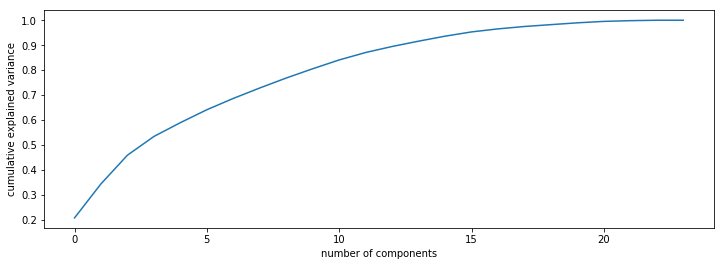

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
GridSearch KNN Best weights: distance
GridSearch KNN Best n_neighbors: 13
GridSearch KNN Default (accuracy) Train Dataset 1.0
GridSearch KNN Default (accuracy) Test Dataset 0.563209689629

GridSearch KNN Default Metric Report:
             precision    recall  f1-score   support

          0       0.55      0.92      0.69       705
          1       0.63      0.16      0.25       616

avg / total       0.59      0.56      0.49      1321

GridSearch KNN Default Confusion Matrix:


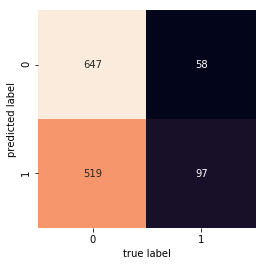

GridSearch KNN ROC Curve
AUROC Score: 0.62899905937


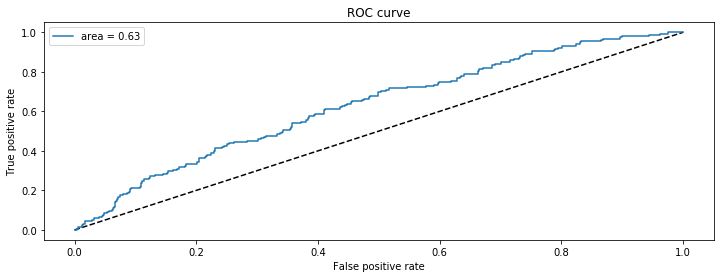

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-14] is [$717.35]
Total investment cost so far is [$15018.4]
Total investment return so far is [$15735.75]
Total investment return % gain so far is [4.776474191658233%]

Top 10 companies by investment profit:
Top 10 Total investment cost so far is [$1882.92]
Top 10 Total investment return so far is [$2200.15]
Top 10 Total investment return % gain so far is [0.16847768359781617%]
                Company  Initial Price  Current Price  Investment Cost  \
0          Netflix Inc.         254.26         321.30           254.26   
1          Lam Research         169.92         228.65           169.92   
2     Adobe Systems Inc         190.27         220.94           190.27   
3          Red Hat Inc.         127.05         155.08           127.05   
4  Grainger (W.W.) Inc.         252.85         279.74           252.85   
5      Sherwin-W

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Activision Blizzard,67.98,76.86,67.98,76.86,8.88
1,Adobe Systems Inc,190.27,220.94,190.27,220.94,30.67
2,AFLAC Inc,85.71,90.83,85.71,90.83,5.12
3,Air Products & Chemicals Inc,156.33,170.88,156.33,170.88,14.55
4,Akamai Technologies Inc,62.81,74.97,62.81,74.97,12.16
5,Alexion Pharmaceuticals,112.72,127.08,112.72,127.08,14.36
6,Ameren Corp,53.69,53.95,53.69,53.95,0.26
7,American Tower Corp A,142.04,145.08,142.04,145.08,3.04
8,AmerisourceBergen Corp,91.54,100.29,91.54,100.29,8.75
9,Amgen Inc.,173.44,189.30,173.44,189.30,15.86


In [92]:
# #analysis target
# how_much_better = 10
# invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

#Feature Scaling and Normalization for Train, Test & Verification dataset
X_train_std_scale, X_test_std_scale, X_ver_std_scale = Standard_Scale(X_train, X_test, X_ver)

#check if there's any need for PCA to reduce number of features
print('Total available features:', len(list(X_train)))
PCA_Component_Analysis(X_train_std_scale)
X_train_std_scale_PCA, X_test_std_scale_PCA, X_ver_std_scale_PCA = PCA_Component_Selection(20, X_train_std_scale, X_test_std_scale, X_ver_std_scale)

#check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

#handling imbalance dataset by down-sampling the train set data
X_train_std_scale_PCA_reduce, y_train_reduce = Down_Sample_Dataset(X_train_std_scale_PCA, y_train)

#model execution with SVM
df_result = GridSearch_KNN_Run(X_train_std_scale_PCA_reduce, y_train_reduce, X_test_std_scale_PCA, y_test, X_ver_std_scale_PCA, calc_return=True)
df_result.to_csv('GridSearch_KNN_Std_Scale_PCA_Down_Sampling.csv', index=False)
df_result

### Stock Analysis using GridSearch + Neural Network + Standard Scale + PCA + Down Sampling Data

Total available features: 24


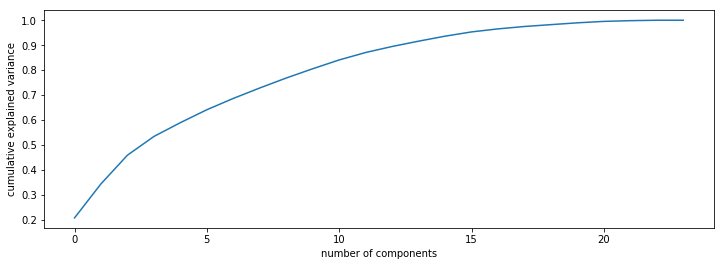

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
GridSearch Neural Network Best activation: tanh
GridSearch Neural Network Best alpha: 10
GridSearch Neural Network Default (accuracy) Train Dataset 0.686550976139
GridSearch Neural Network Default (accuracy) Test Dataset 0.591218773656

GridSearch Neural Network Default Metric Report:
             precision    recall  f1-score   support

          0       0.59      0.92      0.72       744
          1       0.62      0.17      0.26       577

avg / total       0.60      0.59      0.52      1321

GridSearch Neural Network Default Confusion Matrix:


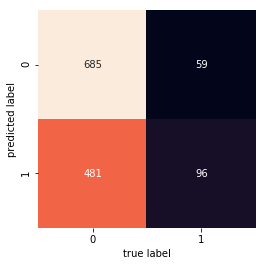

GridSearch Neural Network ROC Curve
AUROC Score: 0.641570298235


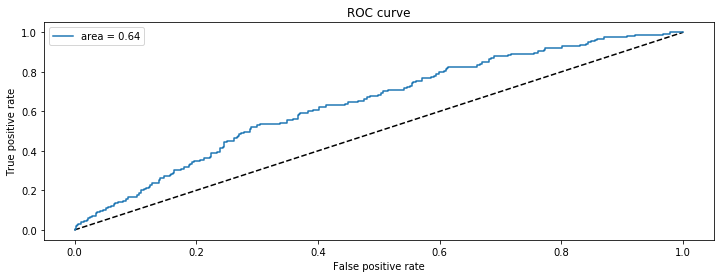

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-14] is [$896.1]
Total investment cost so far is [$15330.65]
Total investment return so far is [$16226.75]
Total investment return % gain so far is [5.845153336616517%]

Top 10 companies by investment profit:
Top 10 Total earning from [2018-02-05] till [2018-03-14] is [$505.94]
Top 10 Total investment cost so far is [$3115.27]
Top 10 Total investment return so far is [$3621.21]
Top 10 Total investment return % gain so far is [16.240646878119712%]
                Company  Initial Price  Current Price  Investment Cost  \
0       Amazon.com Inc.        1390.00        1598.39          1390.00   
1          Netflix Inc.         254.26         321.30           254.26   
2          Lam Research         169.92         228.65           169.92   
3     Adobe Systems Inc         190.27         220.94           190.27   
4          Red Hat In

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Activision Blizzard,67.98,76.86,67.98,76.86,8.88
1,Adobe Systems Inc,190.27,220.94,190.27,220.94,30.67
2,Advanced Micro Devices Inc,11.57,11.52,11.57,11.52,-0.05
3,Aetna Inc,180.95,177.07,180.95,177.07,-3.88
4,Air Products & Chemicals Inc,156.33,170.88,156.33,170.88,14.55
5,Akamai Technologies Inc,62.81,74.97,62.81,74.97,12.16
6,Alexion Pharmaceuticals,112.72,127.08,112.72,127.08,14.36
7,Amazon.com Inc.,1390.00,1598.39,1390.00,1598.39,208.39
8,American Tower Corp A,142.04,145.08,142.04,145.08,3.04
9,AmerisourceBergen Corp,91.54,100.29,91.54,100.29,8.75


In [93]:
# #analysis target
# how_much_better = 10
# invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

#Feature Scaling and Normalization for Train, Test & Verification dataset
X_train_std_scale, X_test_std_scale, X_ver_std_scale = Standard_Scale(X_train, X_test, X_ver)

#check if there's any need for PCA to reduce number of features
print('Total available features:', len(list(X_train)))
PCA_Component_Analysis(X_train_std_scale)
X_train_std_scale_PCA, X_test_std_scale_PCA, X_ver_std_scale_PCA = PCA_Component_Selection(20, X_train_std_scale, X_test_std_scale, X_ver_std_scale)

#check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

#handling imbalance dataset by down-sampling the train set data
X_train_std_scale_PCA_reduce, y_train_reduce = Down_Sample_Dataset(X_train_std_scale_PCA, y_train)

#model execution with GridSearch Neural Network
df_result = GridSearch_NN_Run(X_train_std_scale_PCA_reduce, y_train_reduce, X_test_std_scale_PCA, y_test, X_ver_std_scale_PCA, calc_return=True)
df_result.to_csv('GridSearch_NN_Std_Scale_PCA_Down_Sampling.csv', index=False)
df_result

### Stock Analysis using GridSearch + Gradient-Boosted Decision Tree + Standard Scale + PCA + Down Sampling Data

Total available features: 24


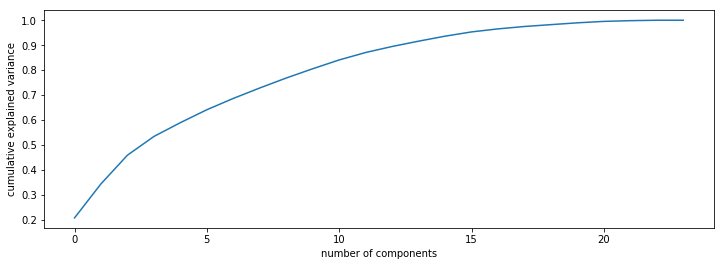

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
GridSearch Gradient-Boosted Decision Trees Best n_estimators: 150
GridSearch Gradient-Boosted Decision Trees Best max_depth: 10
GridSearch Gradient-Boosted Decision Trees Best learning_rate: 0.1
GridSearch Gradient-Boosted Decision Trees Default (accuracy) Train Dataset 1.0
GridSearch Gradient-Boosted Decision Trees Default (accuracy) Test Dataset 0.588190764572

GridSearch Gradient-Boosted Decision Trees Default Metric Report:
             precision    recall  f1-score   support

          0       0.59      0.91      0.72       758
          1       0.56      0.15      0.24       563

avg / total       0.58      0.59      0.51      1321

GridSearch Gradient-Boosted Decision Tr

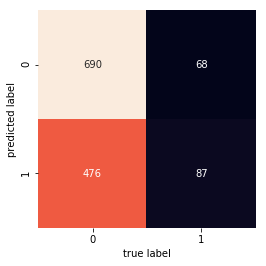

GridSearch Gradient-Boosted Decision Trees ROC Curve
AUROC Score: 0.618995186189


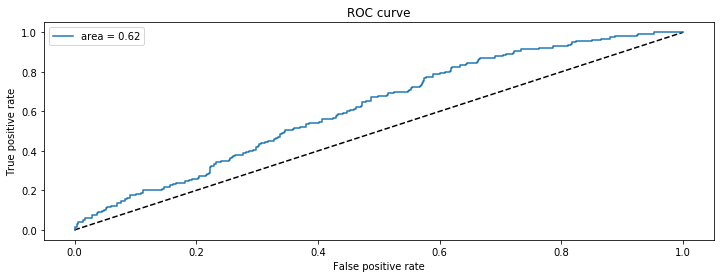

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-14] is [$707.63]
Total investment cost so far is [$14180.1]
Total investment return so far is [$14887.73]
Total investment return % gain so far is [4.990303312388488%]

Top 10 companies by investment profit:
Top 10 Total earning from [2018-02-05] till [2018-03-14] is [$317.89]
Top 10 Total investment cost so far is [$1696.9]
Top 10 Total investment return so far is [$2014.79]
Top 10 Total investment return % gain so far is [18.733572986033355%]
                Company  Initial Price  Current Price  Investment Cost  \
0          Netflix Inc.         254.26         321.30           254.26   
1          Lam Research         169.92         228.65           169.92   
2     Adobe Systems Inc         190.27         220.94           190.27   
3          Red Hat Inc.         127.05         155.08           127.05   
4  Grainger (W.W.) Inc

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Abbott Laboratories,58.73,63.62,58.73,63.62,4.89
1,Activision Blizzard,67.98,76.86,67.98,76.86,8.88
2,Adobe Systems Inc,190.27,220.94,190.27,220.94,30.67
3,Akamai Technologies Inc,62.81,74.97,62.81,74.97,12.16
4,Alexion Pharmaceuticals,112.72,127.08,112.72,127.08,14.36
5,Altria Group Inc,65.34,65.07,65.34,65.07,-0.27
6,Ameren Corp,53.69,53.95,53.69,53.95,0.26
7,American Tower Corp A,142.04,145.08,142.04,145.08,3.04
8,AmerisourceBergen Corp,91.54,100.29,91.54,100.29,8.75
9,Amgen Inc.,173.44,189.30,173.44,189.30,15.86


In [94]:
# #analysis target
# how_much_better = 10
# invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

# #Feature Scaling and Normalization for Train, Test & Verification dataset
X_train_std_scale, X_test_std_scale, X_ver_std_scale = Standard_Scale(X_train, X_test, X_ver)

# #check if there's any need for PCA to reduce number of features
print('Total available features:', len(list(X_train)))
PCA_Component_Analysis(X_train_std_scale)
X_train_std_scale_PCA, X_test_std_scale_PCA, X_ver_std_scale_PCA = PCA_Component_Selection(20, X_train_std_scale, X_test_std_scale, X_ver_std_scale)

# #check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

# #handling imbalance dataset by down-sampling the train set data
X_train_std_scale_PCA_reduce, y_train_reduce = Down_Sample_Dataset(X_train_std_scale_PCA, y_train)

#model execution with SVM
df_result = GridSearch_GBM_Run(X_train_std_scale_PCA_reduce, y_train_reduce, X_test_std_scale_PCA, y_test, X_ver_std_scale_PCA, calc_return=True, printFeatureImportance=False)
df_result.to_csv('GridSearch_GBM_Std_Scale_PCA_Down_Sampling.csv', index=False)
df_result

### Stock Analysis using Gaussian Naive Bayes + Standard Scale + PCA + Down Sampling Data

Total available features: 24


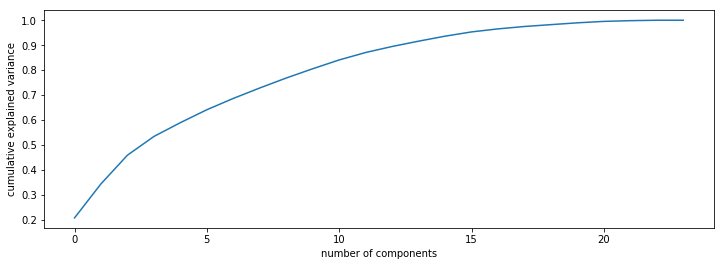

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
Gaussian Naive Bayes Default (accuracy) Train Dataset 0.522776572668
Gaussian Naive Bayes Default (accuracy) Test Dataset 0.828917486752

Gaussian Naive Bayes Default Metric Report:
             precision    recall  f1-score   support

          0       0.92      0.89      0.91      1216
          1       0.11      0.16      0.13       105

avg / total       0.86      0.83      0.84      1321

Gaussian Naive Bayes Default Confusion Matrix:


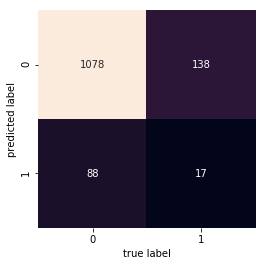

ROC Curve
AUROC Score: 0.595490510707


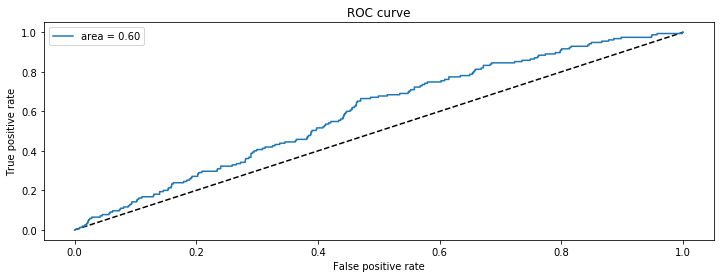

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-14] is [$234.9]
Total investment cost so far is [$3787.62]
Total investment return so far is [$4022.52]
Total investment return % gain so far is [6.201783705862785%]

Top 10 companies by investment profit:
Top 10 Total earning from [2018-02-05] till [2018-03-14] is [$201.44]
Top 10 Total investment cost so far is [$1607.36]
Top 10 Total investment return so far is [$1808.8]
Top 10 Total investment return % gain so far is [12.532351184551066%]
                Company  Initial Price  Current Price  Investment Cost  \
0          Netflix Inc.         254.26         321.30           254.26   
1     Adobe Systems Inc         190.27         220.94           190.27   
2          Red Hat Inc.         127.05         155.08           127.05   
3           Intuit Inc.         157.65         177.33           157.65   
4        Boeing Company 

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Adobe Systems Inc,190.27,220.94,190.27,220.94,30.67
1,Advanced Micro Devices Inc,11.57,11.52,11.57,11.52,-0.05
2,American Tower Corp A,142.04,145.08,142.04,145.08,3.04
3,"AvalonBay Communities, Inc.",159.02,161.54,159.02,161.54,2.52
4,Boeing Company,327.26,344.19,327.26,344.19,16.93
5,C. H. Robinson Worldwide,89.88,91.03,89.88,91.03,1.15
6,Campbell Soup,44.22,43.59,44.22,43.59,-0.63
7,The Clorox Company,127.00,130.37,127.00,130.37,3.37
8,Colgate-Palmolive,69.81,71.08,69.81,71.08,1.27
9,Crown Castle International Corp.,110.51,111.39,110.51,111.39,0.88


In [95]:
# #analysis target
# how_much_better = 10
# invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

# #Feature Scaling and Normalization for Train, Test & Verification dataset
X_train_std_scale, X_test_std_scale, X_ver_std_scale = Standard_Scale(X_train, X_test, X_ver)

# #check if there's any need for PCA to reduce number of features
print('Total available features:', len(list(X_train)))
PCA_Component_Analysis(X_train_std_scale)
X_train_std_scale_PCA, X_test_std_scale_PCA, X_ver_std_scale_PCA = PCA_Component_Selection(20, X_train_std_scale, X_test_std_scale, X_ver_std_scale)

# #check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

# #handling imbalance dataset by down-sampling the train set data
X_train_std_scale_PCA_reduce, y_train_reduce = Down_Sample_Dataset(X_train_std_scale_PCA, y_train)

#model execution with Gaussian Naive Bayes
df_result = GNB_Run(X_train_std_scale_PCA_reduce, y_train_reduce, X_test_std_scale_PCA, y_test, X_ver_std_scale_PCA, calc_return=True)
df_result.to_csv('GNB_Std_Scale_PCA_Down_Sampling.csv', index=False)
df_result

### Stock Analysis using Voting Ensemble + Standard Scale + PCA + Down Sampling Data

Total available features: 24


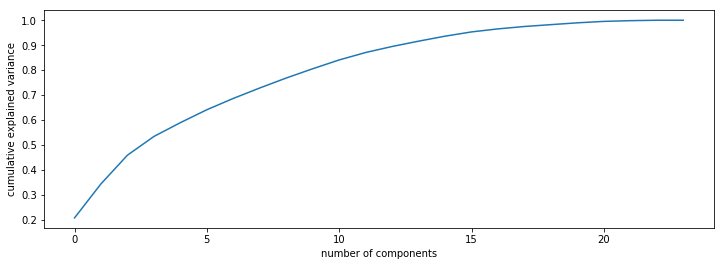

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
Voting Ensemble Default (accuracy) Train Dataset 0.700650759219
Voting Ensemble Default (accuracy) Test Dataset 0.529144587434

Voting Ensemble Default Metric Report:
             precision    recall  f1-score   support

          0       0.52      0.91      0.66       660
          1       0.63      0.15      0.24       661

avg / total       0.57      0.53      0.45      1321

Voting Ensemble Default Confusion Matrix:


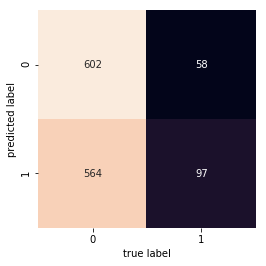

ROC Curve
AUROC Score: 0.636695623305


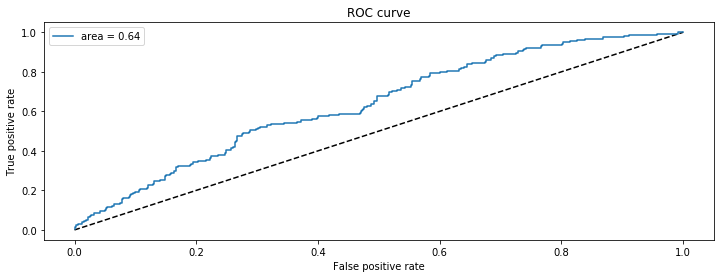

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-14] is [$740.42]
Total investment cost so far is [$15785.75]
Total investment return so far is [$16526.17]
Total investment return % gain so far is [4.6904328270750515%]

Top 10 companies by investment profit:
Top 10 Total earning from [2018-02-05] till [2018-03-14] is [$319.21]
Top 10 Total investment cost so far is [$2122.8]
Top 10 Total investment return so far is [$2442.01]
Top 10 Total investment return % gain so far is [15.037214999057845%]
                  Company  Initial Price  Current Price  Investment Cost  \
0            Netflix Inc.         254.26         321.30           254.26   
1            Lam Research         169.92         228.65           169.92   
2       Adobe Systems Inc         190.27         220.94           190.27   
3            Red Hat Inc.         127.05         155.08           127.05   
4    Grain

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Accenture plc,151.83,161.69,151.83,161.69,9.86
1,Activision Blizzard,67.98,76.86,67.98,76.86,8.88
2,Adobe Systems Inc,190.27,220.94,190.27,220.94,30.67
3,Advanced Micro Devices Inc,11.57,11.52,11.57,11.52,-0.05
4,Aetna Inc,180.95,177.07,180.95,177.07,-3.88
5,Air Products & Chemicals Inc,156.33,170.88,156.33,170.88,14.55
6,Akamai Technologies Inc,62.81,74.97,62.81,74.97,12.16
7,Alexion Pharmaceuticals,112.72,127.08,112.72,127.08,14.36
8,American Tower Corp A,142.04,145.08,142.04,145.08,3.04
9,AmerisourceBergen Corp,91.54,100.29,91.54,100.29,8.75


In [96]:
# #analysis target
# how_much_better = 10
# invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

# #Feature Scaling and Normalization for Train, Test & Verification dataset
X_train_std_scale, X_test_std_scale, X_ver_std_scale = Standard_Scale(X_train, X_test, X_ver)

# #check if there's any need for PCA to reduce number of features
print('Total available features:', len(list(X_train)))
PCA_Component_Analysis(X_train_std_scale)
X_train_std_scale_PCA, X_test_std_scale_PCA, X_ver_std_scale_PCA = PCA_Component_Selection(20, X_train_std_scale, X_test_std_scale, X_ver_std_scale)

# #check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

# #handling imbalance dataset by down-sampling the train set data
X_train_std_scale_PCA_reduce, y_train_reduce = Down_Sample_Dataset(X_train_std_scale_PCA, y_train)

#model execution with Voting Ensemble
df_result = VE_Run(X_train_std_scale_PCA_reduce, y_train_reduce, X_test_std_scale_PCA, y_test, X_ver_std_scale_PCA, calc_return=True)
df_result.to_csv('VE_Std_Scale_PCA_Down_Sampling.csv', index=False)
df_result

### Conclusion

With Neural Network, the best estimated model is using the combination of:

"Stock Analysis using GridSearch + Neural Network + Standard Scale + PCA + Down Sampling Data"

with 

- GridSearch Neural Network Best activation: tanh
- GridSearch Neural Network Best alpha: 10
- GridSearch Neural Network Default (accuracy) Train Dataset 0.686550976139
- GridSearch Neural Network Default (accuracy) Test Dataset 0.591218773656

- GridSearch Neural Network Default Metric Report:
                     precision    recall  f1-score   support

                  0       0.59      0.92      0.72       744
                  1       0.62      0.17      0.26       577

        avg / total       0.60      0.59      0.52      1321

- AUROC Score: 0.641570298235
- Top 10 investments total return % gain from [2018-02-05] till [2018-03-13] is 16.24%
       
| Company         |
|---------------  |
| `Amazon.com Inc.`	  |
| `Netflix Inc.` |
| `Lam Research`        |
| `Adobe Systems Inc`   |
| `Red Hat Inc.`   |
| `Grainger (W.W.) Inc.`   |
| `Sherwin-Williams`   |
| `KLA-Tencor Corp.`   |
| `Western Digital`   |
| `Cintas Corporation`   |

     


# Summary

Based on all analysis did with using Support Vector Machine, Logistic Regression, Random Forest, Gradient-boosted decision trees, Nueral Network, K-Nearest Neighbours, the best model choosen is Random Forest.

with 

- GridSearch Random Forest Best n_estimators: 30
- GridSearch Random Forest Best max_depth: 5
- GridSearch Random Forest Best min_samples_leaf: 6
- GridSearch Random Forest Default (accuracy) Train Dataset 0.759219088937
- GridSearch Random Forest Default (accuracy) Test Dataset 0.567751703255

- GridSearch Random Forest Default Metric Report:
                     precision    recall  f1-score   support

                  0       0.55      0.93      0.69       691
                  1       0.69      0.17      0.27       630

         avg / total      0.62      0.57      0.49      1321

- AUROC Score: 0.665401427544
- Top 10 investments total return % gain from [2018-02-05] till [2018-03-13] is 15.15%

| Company         |
|---------------  |
| `Lam Research`	  |
| `Adobe Systems Inc` |
| `Red Hat Inc.`        |
| `Grainger (W.W.) Inc.`   |
| `Western Digital`   |
| `Intuit Inc.`   |
| `KLA-Tencor Corp.`   |
| `Cintas Corporation`   |
| `Fiserv Inc`   |
| `Roper Technologies`   |

### Future Enhancement

1. Perform mathematic calculation to calculate the missing financial statistic data and ratio
2. Download Key Financial Statistic data from Yahoo Finance regulary within a fixed interval for example monthly interval. A job schedule could be setup to perform the task automatically.
3. Perform comprehensive feature selection to identify and remove unneeded, irrelevant and redundant attributes from data that do not contribute to the accuracy of a predictive model. Method like Recursive Feature Elimination (RFE) could be used and in-depth understanding of the financial analysis will help to select relevant feature also to avoid multicollinearity issue.
4. As some financial ratio are industy specific, hence, it is viable to perform analysis on stock based on industry and sub-industry group instead of general analysis on all stock from different industries. 
5. Perform comprehensive fine tuning on model hypermarameters to optimize model prediction accuracy
6. By incorporating The CBOE Volatility Index into analysis, known by its ticker symbol VIX, which is a popular measure of the stock market's expectation of volatility implied by S&P 500 index options, calculated and published by the Chicago Board Options Exchange (CBOE). It is colloquially referred to as the fear index or the fear gauge.
7. Make use of Quantopian to  of https://www.quantopian.com/ to write investment algorithms with its hosted IPython environment using stock price history, corporate fundamental data, and other data. The best algorithms are eligible to receive capital allocations from Quantopian. If your algorithm is selected for an allocation, you get a share of your algorithm's net profits.